<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/Random_Forest_for_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Required Libraries

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

#2. Mount Google Drive

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Load Training and Test Data

In [24]:
train_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/train_forecast_data.csv'
test_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/test_forecast_data.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#3. Select Features

In [25]:
features=['Account', 'Product', 'Type', 'Lag_Qty_1', 'Lag_Qty_2', 'Lag_Rev_1', 'Lag_Rev_2',
            'Rolling_Qty_3', 'Rolling_Rev_3']

target_quantity='Forecast_Quantity'
target_revenue='Forecast_Revenue'

#4. Drop Rows with Missing Features

In [26]:
train_df = train_df.dropna(subset=features + [target_quantity, target_revenue])
test_df = test_df.dropna(subset=features + [target_quantity, target_revenue])

X_train = train_df[features]
X_test = test_df[features]

y_train_qty = train_df[target_quantity]
y_test_qty = test_df[target_quantity]

y_train_rev = train_df[target_revenue]
y_test_rev = test_df[target_revenue]

#5. Define Preprocessing for Categorical Columns

In [27]:
categorical_features = ['Account', 'Product', 'Type']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep numerical columns
)

#6. Define Hyperparameter Grids

In [28]:
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

#7. Build RandomizedSearchCV Model

In [29]:
def build_tuned_model(X, y, label=""):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=20,
        cv=3,
        verbose=2,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1
    )

    print(f"\n🔍 Tuning hyperparameters for {label} model...")
    search.fit(X, y)
    print(f"✅ Best params for {label}: {search.best_params_}")
    return search.best_estimator_

#8. Train the Models

In [30]:
model_qty = build_tuned_model(X_train, y_train_qty, label="Quantity")
model_rev = build_tuned_model(X_train, y_train_rev, label="Revenue")


🔍 Tuning hyperparameters for Quantity model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

✅ Best params for Quantity: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20}

🔍 Tuning hyperparameters for Revenue model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best params for Revenue: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 30}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

#8. Predict and Evaluate

In [32]:
def evaluate_model(model, X, y_true, label=""):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y_true, y_pred) # Removed squared=False
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {label} Forecasting Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.4f}")
    return y_pred

# Quantity Evaluation
y_pred_qty = evaluate_model(model_qty, X_test, y_test_qty, "Quantity")

# Revenue Evaluation
y_pred_rev = evaluate_model(model_rev, X_test, y_test_rev, "Revenue")


📊 Quantity Forecasting Results:
  RMSE: 66761.52
  MAE : 158.54
  R²  : 0.5042

📊 Revenue Forecasting Results:
  RMSE: 638602986.49
  MAE : 11080.95
  R²  : 0.0996


#9. Feature Importance

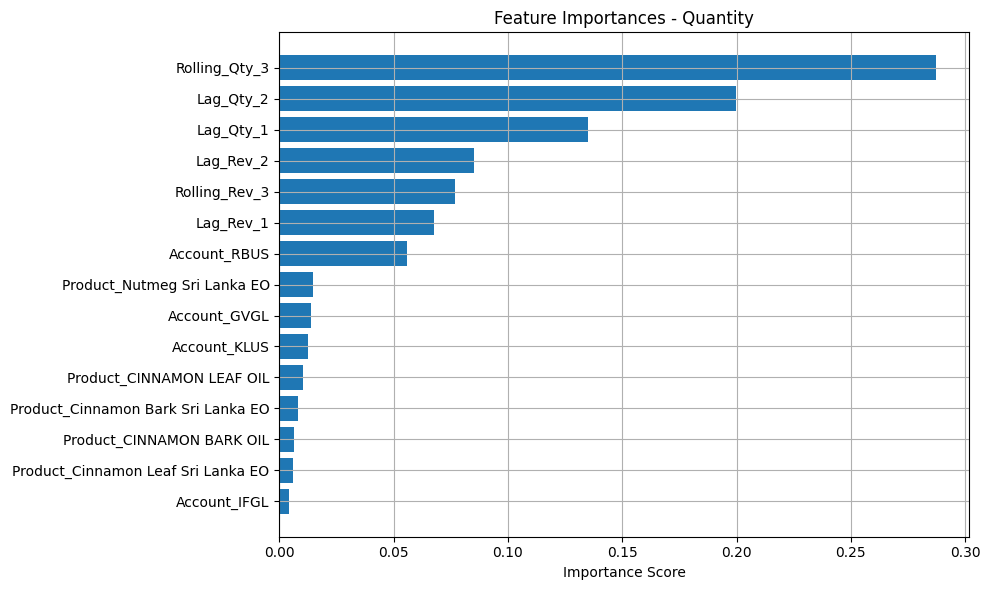

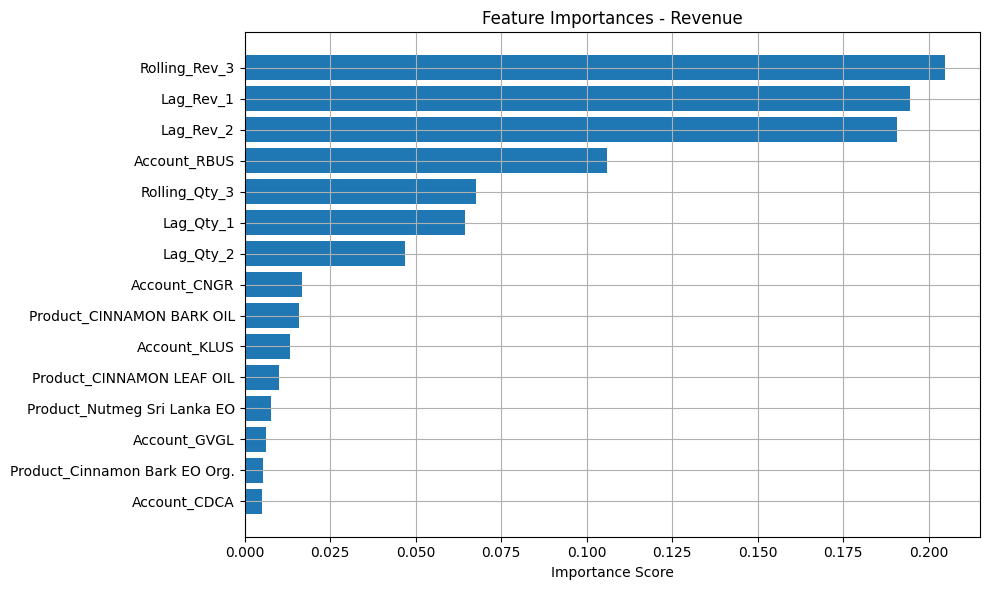

In [33]:
def plot_feature_importances(model, feature_names, title):
    # Get feature names after one-hot encoding
    encoded_cat = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    all_feature_names = np.concatenate([encoded_cat, features[3:]])  # append numerical features
    importances = model.named_steps['regressor'].feature_importances_

    # Sort
    sorted_idx = np.argsort(importances)[-15:]  # top 15
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
    plt.title(f'Feature Importances - {title}')
    plt.xlabel('Importance Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importances(model_qty, features, "Quantity")
plot_feature_importances(model_rev, features, "Revenue")

#10. Plot Prediction vs Actual

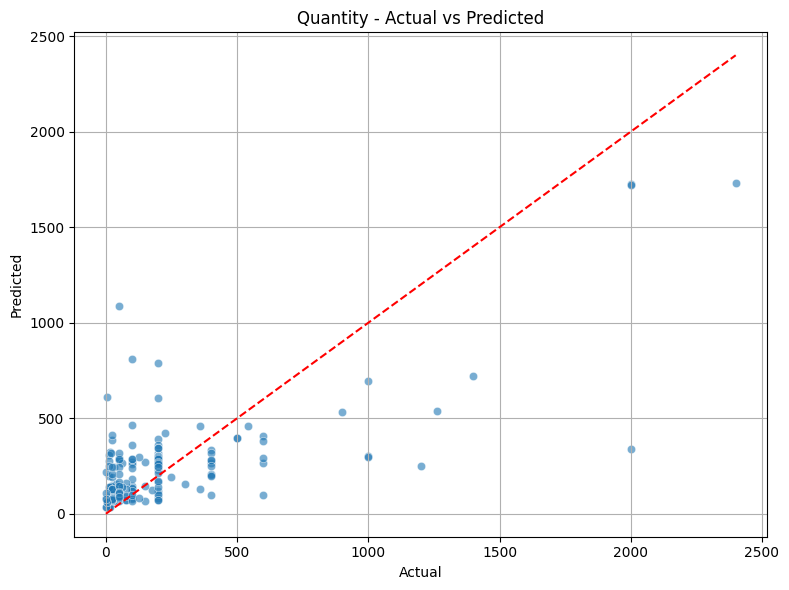

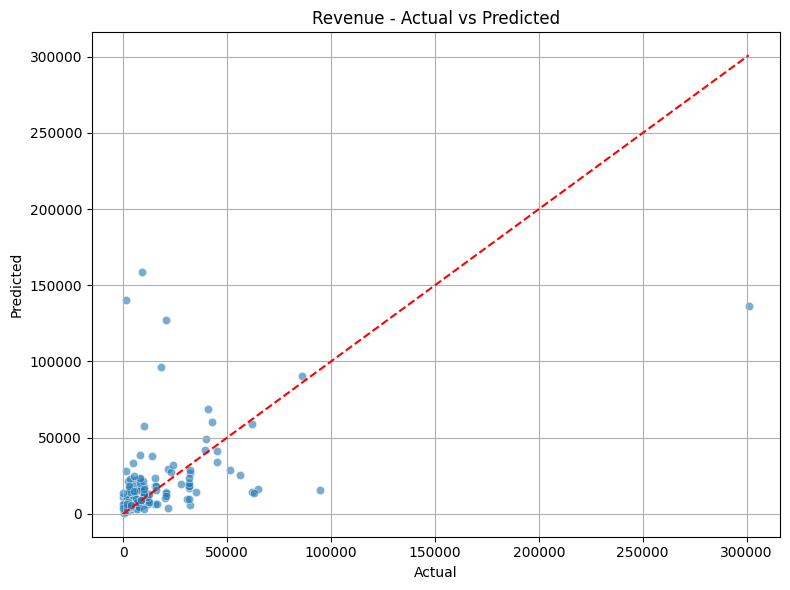

In [34]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title} - Actual vs Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_predictions(y_test_qty, y_pred_qty, "Quantity")
plot_predictions(y_test_rev, y_pred_rev, "Revenue")

#11. Plot Residuals

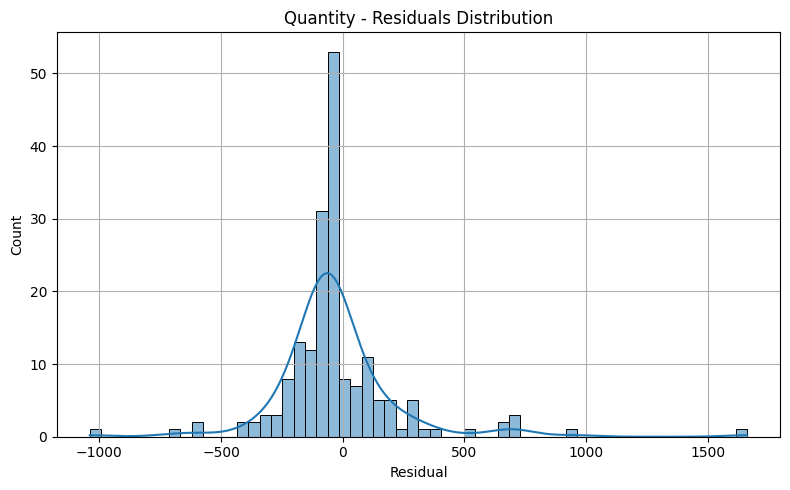

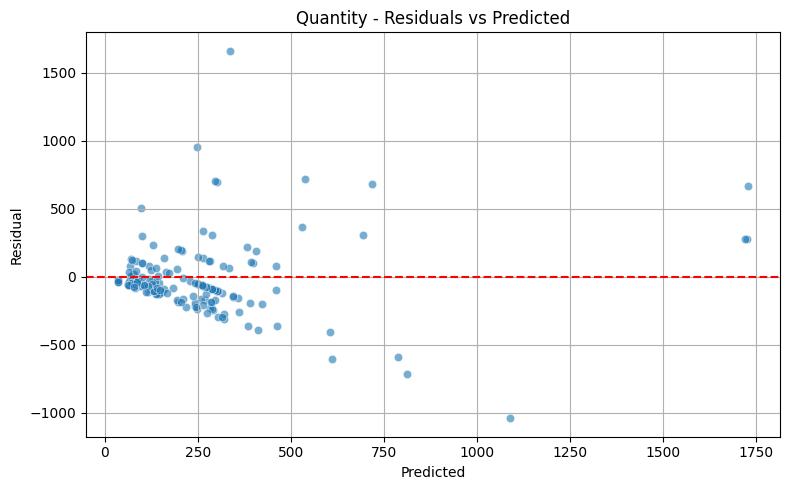

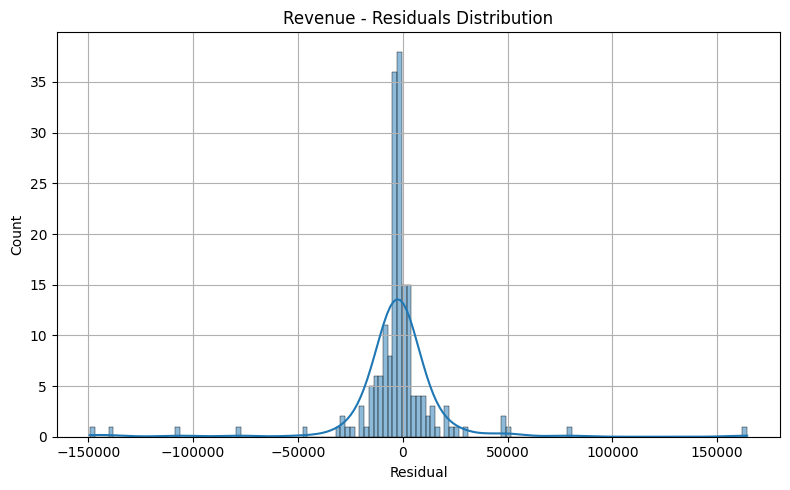

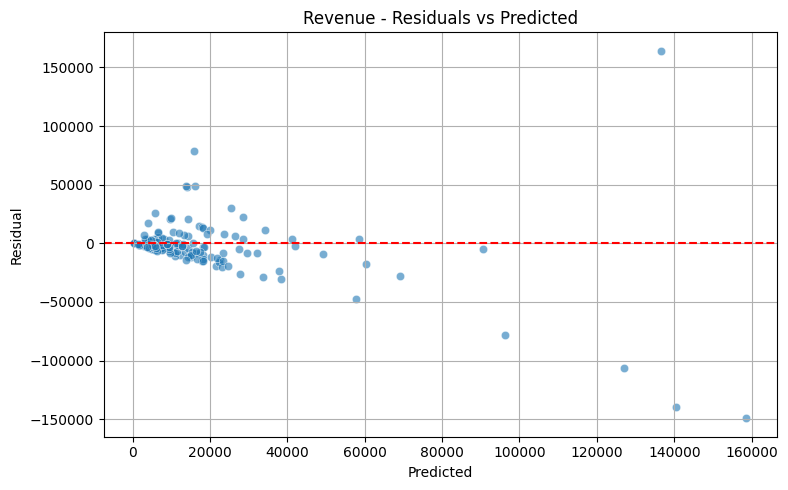

In [35]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f'{title} - Residuals Distribution')
    plt.xlabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals vs Predicted
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'{title} - Residuals vs Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_residuals(y_test_qty, y_pred_qty, "Quantity")
plot_residuals(y_test_rev, y_pred_rev, "Revenue")